In [3]:
# Import Requirements
import pandas as pd
from tqdm import tqdm as tq

Pre-Processing Function

In [5]:
def pre_processing_profiles(df):
    list_null=[]
    for i in df.columns:
        if df[i].isna().sum()>0:
            list_null.append(i)
    for j in list_null:
        if j=='firstname_lastname':
            df[j].fillna('',inplace=True)  ##Replace NAN username with empty string
        elif j=='description':
            df[j].fillna('',inplace=True)  ##Replcae NAN profile description as empty string
        elif j=='following':
            df[j].fillna(0,inplace=True)  ##Replcae NAN following(number of other instagram profiles being followed by the user) as 0
        elif j=='followers':
            df[j].fillna(0,inplace=True)  ##Replcae NAN followers(number of other instagram profile following the user) as 0
        elif j=='n_posts':
            df[j].fillna(0,inplace=True)  ##Replcae NAN number of posts by the user as 0
        elif j=='url':
            df[j].fillna('',inplace=True)  ##Replcae NAN profile link as empty string
        elif j=='cts':
            df[j]=pd.to_datetime(df[j],utc=True)
        elif j=='is_business_account':
            df[j].fillna(False,inplace=True) ## Assuming the NAN field in 'is_buisness_account' column corresponds to False(it is not a buisness account)
    
    return df

In [3]:
def pre_processing_posts(df):
    list_null=[]
    for i in df.columns:
        if df[i].isna().sum()>0:
            list_null.append(i)
    for j in list_null:
        if j=='profile_id':
            df[j].fillna(0,inplace=True)  ##Replace Null Profile ID with empty string
        elif j=='description':
            df[j].fillna('',inplace=True) ## Replace NAN values with empty string
    
    return df

RQ-2.1 Plot the number of posts for each profile in descending order.

In [ ]:


for j,i in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_profiles.csv',sep='\t',usecols=['profile_id','n_posts'],chunksize=10000))):
    if j==0:
        i=pre_processing_profiles(i)
        df_nposts=i
    else:
        i=pre_processing(i)
        df_nposts=pd.concat([df_nposts,i],axis=0)

df_nposts.sort_values(by='n_posts',ascending=False)
df_nposts['n_posts'].plot(x=df_nposts['profile_id'],y=df_nposts['n_posts'],xlabel='PROFILE ID',ylabel='Number of Posts')

9981it [02:34, 33.92it/s] 

RQ 2.2 What posts have the highest number of "likes"?

In [39]:

for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_id','numbr_likes'],sep='\t',chunksize=40000))):
    if i==0:
        df_likes=chunk.sort_values(by='numbr_likes',ascending=False).head(1)
    else:
        i=chunk.sort_values(by='numbr_likes',ascending=False).head(1)
        df_likes=pd.concat([df_likes,i],axis=0)

df_likes=df_likes.sort_values(by='numbr_likes',ascending=False)
print('The post with post-id {0} has {1} number of likes which is the maximum among the dataset'.format(str(df_likes['post_id'].head(1).values[0]),str(df_likes['numbr_likes'].head(1).values[0])))    

    

106776it [09:56, 179.12it/s]

The post with post-id Bt3yaXmAM0d has 8822952.0 number of likes which is the maximum among the dataset


RQ2.3 What posts have the most and the least number of comments?

In [47]:
for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_id','number_comments'],sep='\t',chunksize=10000))):
    chunk=pre_processing_posts(chunk)      ###Remove NAN
    if i==0:
        df_max_comments=chunk.sort_values(by='number_comments',ascending=False).head(1) ##Sort chunk in Descending order and get the biggest value from chunk
        df_min_comments=chunk.sort_values(by='number_comments',ascending=False).tail(1)  ##Sort chunk in Descending order and get the lowest value from chunk
        
    else:
        i_max=chunk.sort_values(by='number_comments',ascending=False).head(1)
        i_min=chunk.sort_values(by='number_comments',ascending=False).tail(1)
        df_max_comments=pd.concat([df_max_comments,i_max],axis=0)     ##Concatenate data chunks of biggest values.I try to retain datafram structure to leverage dataframe functionalites for analysis.
        df_min_comments=pd.concat([df_min_comments,i_min],axis=0)
df_max_comments=df_max_comments.sort_values(by='number_comments',ascending=False)
print('The post with post-id {0} has {1} number of comments which is maximum among the dataset'.format(str(df_max_comments['post_id'].head(1).values[0]),str(df_max_comments['number_comments'].head(1).values[0])))    
df_min_comments=df_min_comments.sort_values(by='number_comments',ascending=True)
print('The post with post-id {0} has {1} number of comments which is minimum among the dataset'.format(str(df_min_comments['post_id'].head(1).values[0]),str(df_min_comments['number_comments'].head(1).values[0])))    

 

4272it [03:33, 19.97it/s]


RQ 2.4 How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results

451it [02:33,  2.94it/s]


In [ ]:
RQ 2.5 How many posts include only photos? How many also have videos?

In [63]:
for i,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_posts.csv',usecols=['post_type'],sep='\t',chunksize=10000))):
    chunk=pre_processing_posts(chunk)  
    if i==0:  
        count_photos=len(chunk[chunk['post_type']==1]) ##Filter by post_type column values to identify rows with only photos
        count_videos=len(chunk[chunk['post_type']==2])
    else:
        count_photos=count_photos+len(chunk[chunk['post_type']==1])
        count_videos=count_videos+len(chunk[chunk['post_type']==2])


print('The total number of posts with only photos is {}'.format(count_photos))
      
print('The total number of posts with only videos is {}'.format(count_videos))

4272it [02:53, 24.67it/s]

The total number of posts with only photos is 41534486
The total number of posts with only videos is 1134768


RQ2.6 What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

In [22]:
for j,chunk in tq(enumerate(pd.read_csv('/home/ec2-user/SageMaker/Data/instagram_profiles.csv',sep='\t',usecols=['n_posts','followers','following','is_business_account'],chunksize=10000))):
    chunk=pre_processing_profiles(chunk)
    if j==0:
        count_true=len(chunk[chunk['is_business_account']==True].index)
        true_followers=chunk[chunk['is_business_account']==True]['followers'].sum()
        true_following=chunk[chunk['is_business_account']==True]['following'].sum()
        true_nposts=chunk[chunk['is_business_account']==True]['n_posts'].sum()

        
        count_false=len(chunk.index)-count_true
        false_followers=chunk[chunk['is_business_account']==False]['followers'].sum()
        false_following=chunk[chunk['is_business_account']==False]['following'].sum()
        false_nposts=chunk[chunk['is_business_account']==False]['n_posts'].sum()

    else:
        count_true+=len(chunk[chunk['is_business_account']==True].index)
        true_followers+=chunk[chunk['is_business_account']==True]['followers'].sum()
        true_following+=chunk[chunk['is_business_account']==True]['following'].sum()
        true_nposts+=chunk[chunk['is_business_account']==True]['n_posts'].sum()
        
        count_false+=len(chunk[chunk['is_business_account']==False].index)
        false_followers+=chunk[chunk['is_business_account']==False]['followers'].sum()
        false_following+=chunk[chunk['is_business_account']==False]['following'].sum()
        false_nposts+=chunk[chunk['is_business_account']==False]['n_posts'].sum()



451it [00:10, 43.34it/s]


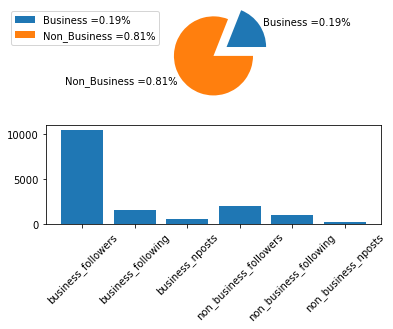

In [55]:
import matplotlib.pyplot as plt
plt.subplot(2,1,1)
mylabels=['Business ='+str(round(count_true/(count_true+count_false),2))+'%','Non_Business ='+str(round(count_false/(count_true+count_false),2))+'%']
plt.pie([round(count_true/(count_true+count_false),2),round(count_false/(count_true+count_false),2)],labels=mylabels,explode=[0.4,0])
plt.legend(bbox_to_anchor=(-0.5,0,0.5,1))

plt.subplot(2,1,2)
plt.bar([str('business_followers'),str('business_following'),str('business_nposts'),str('non_business_followers'),str('non_business_following'),str('non_business_nposts')],
        [true_followers/count_true,true_following/count_true,true_nposts/count_true,false_followers/count_false,false_following/count_false,false_nposts/count_false])
plt.xticks(rotation=45)
plt.show()



On average though business account profiles account for 19% of the dataset they have a big reach in terms of people following their accounts when compared to non_business account which are 81% of the dataset.Consequently, the posts made by business account are noticed/affects much higher percentage of the users as compared to non_business account.

In [6]:
import numpy as np
pd.DatetimeIndex(np.NaN)

TypeError: DatetimeIndex(...) must be called with a collection of some kind, nan was passed